In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

In [2]:
train = pd.read_csv('/content/drive/My Drive/Github/Document Classification/BBC News Train.csv')
test = pd.read_csv('/content/drive/My Drive/Github/Document Classification/BBC News Test.csv')

In [3]:
train['category_id'] = train['Category'].factorize()[0]
train.head()

,ArticleId,Text,Category,category_id
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0


# Data Exploration

In [4]:
# Check for null values
train[train['Text'].isnull()]
train[train['ArticleId'].isnull()]
train[train['Category'].isnull()]
# NO NULL VALUES

,ArticleId,Text,Category,category_id


In [5]:
# Check for duplicate
train[train.duplicated()]
# NO DUPLICATE FOUND

,ArticleId,Text,Category,category_id


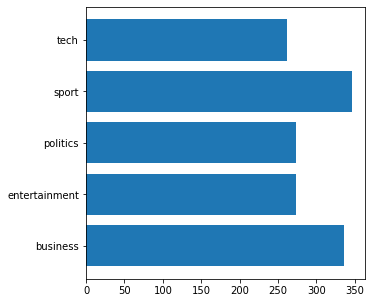

In [6]:
#@title Bar Chart for Category
category = train.groupby(['Category'])[['ArticleId']].count()
plt.figure(figsize=(5,5))
plt.barh(category.index,category['ArticleId'],data=category)
plt.show()

# Data Preprocessing

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create TfidVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
# Vectorize train set
features = tfidf.fit_transform(train.Text).toarray()
labels = train.category_id
# Vectorize test set
test_features = tfidf.transform(test.Text).toarray()
# Shape of Vector
test_features.shape

(735, 9927)

In [9]:
# Dictionary to translate
category_to_id = {'business':0, 'tech':1, 'politics':2, 'sport':3, 'entertainment':4}
id_to_category = {0: 'business', 1: 'tech', 2: 'politics', 3: 'sport', 4: 'entertainment'}

In [ ]:
from sklearn.feature_selection import chi2
N=3
for Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)                   
  indices = np.argsort(features_chi2[0])                                 
  feature_names = np.array(tfidf.get_feature_names())[indices]           
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          
  print("# '{}':".format(Category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) 
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) 

# 'business':
  . Most correlated unigrams:
       . growth
       . bank
       . shares
  . Most correlated bigrams:
       . stock market
       . economic growth
       . analysts said
# 'entertainment':
  . Most correlated unigrams:
       . singer
       . actor
       . film
  . Most correlated bigrams:
       . won best
       . los angeles
       . box office
# 'politics':
  . Most correlated unigrams:
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . prime minister
       . tony blair
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . match
       . coach
       . cup
  . Most correlated bigrams:
       . grand slam
       . champions league
       . australian open
# 'tech':
  . Most correlated unigrams:
       . technology
       . software
       . users
  . Most correlated bigrams:
       . anti virus
       . mobile phones
       . mobile phone


In [ ]:
##dimension reduction 
from sklearn.manifold import TSNE

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)          # Randomly select 30 % of samples
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices]) # Array of all projected features of 30% of Randomly chosen samples 

# Train Model

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
X_test.shape

(298, 9927)

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

lr = LogisticRegression(random_state=0)
knn = KNeighborsClassifier(n_neighbors=5)
rfc = RandomForestClassifier(n_estimators=200,max_depth=3)
NB = MultinomialNB()
svc = SVC(kernel='rbf', degree=10 ,C = 100, gamma =0.001)
classifiers = {('Log Reg', lr),
               ('Knn', knn),                            
               ('Random Forest Classifier', rfc),
               ('NB', NB),
               ('SVM', svc)}
for clf_name, clf in classifiers:
  c = clf
  c.fit(X_train, y_train)
  y_pred = c.predict(X_test)
  print(clf_name, accuracy_score(y_test, y_pred))

Knn 0.9563758389261745
Log Reg 0.9832214765100671
SVM 0.9697986577181208
NB 0.9832214765100671
Random Forest Classifier 0.8489932885906041


In [30]:
model = MultinomialNB()
model.fit(features,labels)
# y_pred = c.predict(features)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [42]:
demo = 'goal'

In [43]:
class_id = model.predict(tfidf.transform([demo]))
id_to_category[class_id[0]]

'sport'

In [36]:
import pickle
import os
save_path = '/content/drive/My Drive/Github/Document Classification'
pickle.dump(model, open(os.path.join(save_path,'document_classifier.pkl'), 'wb'))